#Import all the libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import img_to_array

#Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


#Load the dataset

In [ ]:
# Setting the correct dataset path inside the Google Drive
dataset_path = '/content/drive/MyDrive/AI and ML Workshop/Week-4/DevanagariHandwrittenDigitDataset/Train'


# Load, pre-process and add noise to the dataset

In [ ]:

# Loading the images
def load_images(dataset_path, image_size=(32, 32)):
    data = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                try:
                    img = Image.open(img_path).convert('L')  # grayscale
                    img = img.resize(image_size)
                    img = img_to_array(img) / 255.0  # Normalizing
                    data.append(img)
                except:
                    pass
    return np.array(data)

images = load_images(dataset_path)
images = images.reshape(-1, 32, 32, 1)  # reshaping for CNN input

# Adding noise (Gaussian)
def add_noise(data, noise_factor=0.5):
    noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy, 0., 1.)

noisy_images = add_noise(images)

# Splitting the dataset
x_train, x_test, x_train_noisy, x_test_noisy = train_test_split(
    images, noisy_images, test_size=0.2, random_state=42
)

# Build convolution denoising autocoder model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape)

    # Encoding
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoding
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,041 (652.50 KB)

 Trainable params: 167,041 (652.50 KB)

 Non-trainable params: 0 (0.00 B)

# Train the autoencoder

In [ ]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.4329 - val_loss: 0.1834
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1785 - val_loss: 0.1690
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1678 - val_loss: 0.1619
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1618 - val_loss: 0.1580
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1588 - val_loss: 0.1562
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1551 - val_loss: 0.1541
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1537 - val_loss: 0.1516
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1518 - val_loss: 0.1523
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1510 - val_loss: 0.1495
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1495 - val_loss: 0.1483
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1487 - val_loss: 0.1477
Epoch 12/20
107/107 ━━━━━━━━━━━━━━━━━━━━

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


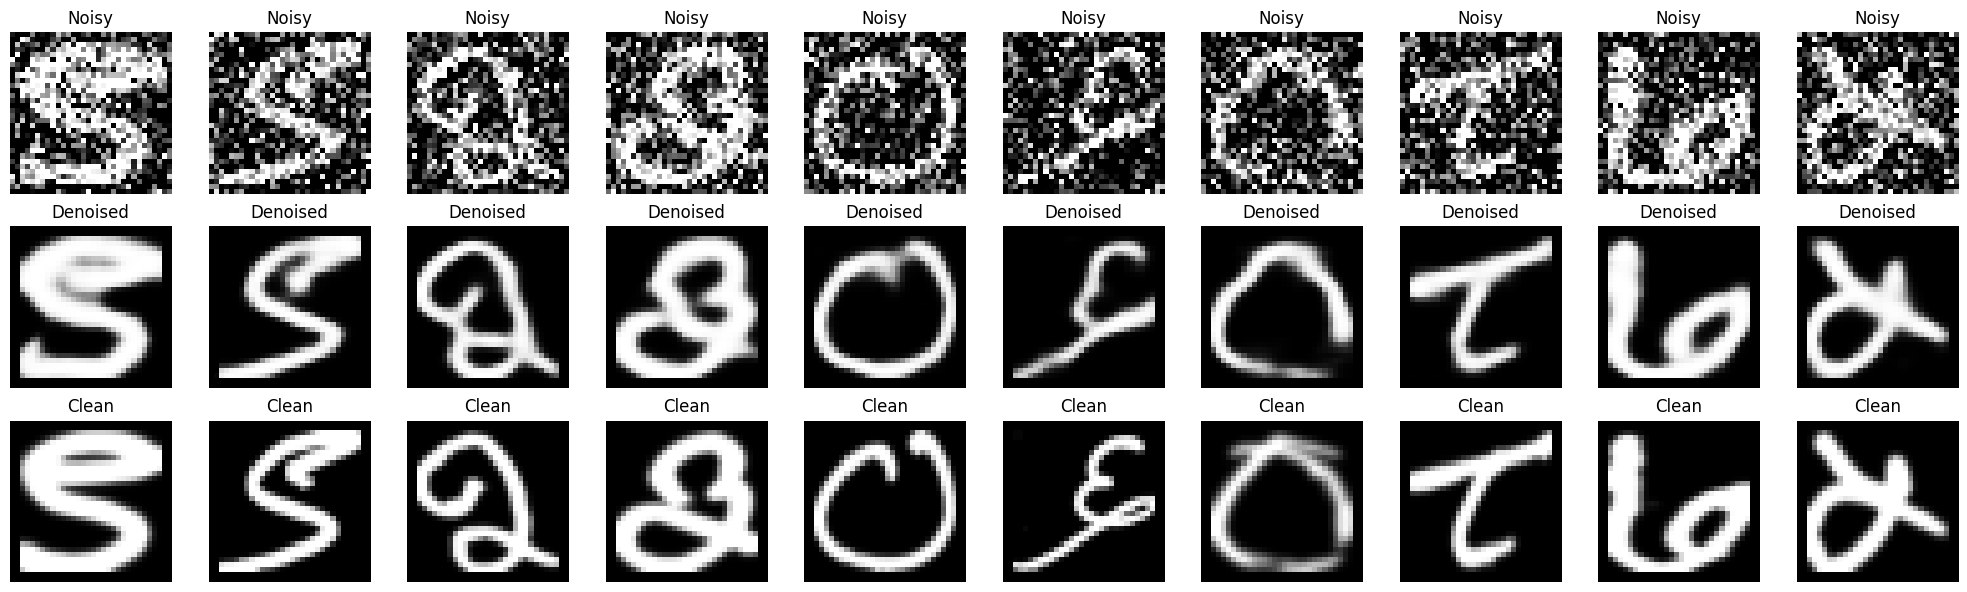

In [ ]:
def plot_images(noisy, denoised, clean, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoising
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Cleaning
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean[i].reshape(32, 32), cmap='gray')
        plt.title("Clean")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predicting
denoised_images = autoencoder.predict(x_test_noisy)
plot_images(x_test_noisy, denoised_images, x_test)


In [ ]:
def salt_pepper_noise(image, amount=0.01):
    noisy = image.copy()
    row, col, ch = image.shape[1], image.shape[2], image.shape[3]
    num_salt = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape[1:3]]
    noisy[:, coords[0], coords[1], :] = 1

    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape[1:3]]
    noisy[:, coords[0], coords[1], :] = 0
    return noisy


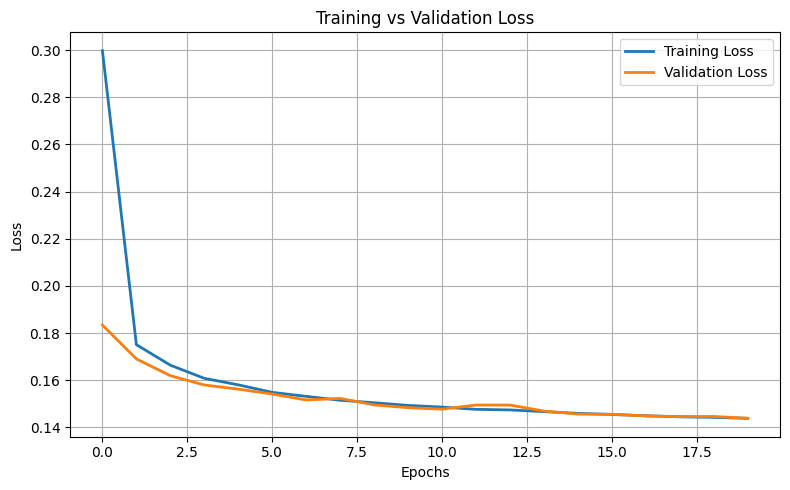

In [ ]:
# 3.1 VISUALIZING TRAINING & VALIDATION LOSS

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Experiment

In [ ]:

# Loading the images
def load_images(dataset_path, image_size=(32, 32)):
    data = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                try:
                    img = Image.open(img_path).convert('L')  # grayscale
                    img = img.resize(image_size)
                    img = img_to_array(img) / 255.0  # Normalizing
                    data.append(img)
                except:
                    pass
    return np.array(data)

images = load_images(dataset_path)
images = images.reshape(-1, 32, 32, 1)  # reshaping for CNN input

# Adding noise (Gaussian)
def add_noise(data, noise_factor=0.5):
    noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy, 0., 1.)

noisy_images = add_noise(images)

# Splitting the dataset
x_train, x_test, x_train_noisy, x_test_noisy = train_test_split(
    images, noisy_images, test_size=0.2, random_state=42
)

In [ ]:

# Trying different noise levels
noisy_images_low = add_noise(images, noise_factor=0.3)
noisy_images_high = add_noise(images, noise_factor=0.7)

# Splitting again for new noise factors
x_train_l, x_test_l, x_train_noisy_l, x_test_noisy_l = train_test_split(images, noisy_images_low, test_size=0.2, random_state=42)
x_train_h, x_test_h, x_train_noisy_h, x_test_noisy_h = train_test_split(images, noisy_images_high, test_size=0.2, random_state=42)


In [ ]:

# Deeper Autoencoder
def build_deeper_autoencoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Extra layer
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

deeper_autoencoder = build_deeper_autoencoder()
deeper_autoencoder.fit(x_train_noisy, x_train, epochs=3, batch_size=128, validation_split=0.1)


Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 0.4889 - val_loss: 0.2594
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2371 - val_loss: 0.2004
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1945 - val_loss: 0.1819


In [ ]:

# Shallower Autoencoder
def build_shallower_autoencoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

shallower_autoencoder = build_shallower_autoencoder()
shallower_autoencoder.fit(x_train_noisy, x_train, epochs=3, batch_size=128, validation_split=0.1)


Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.4673 - val_loss: 0.1835
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1777 - val_loss: 0.1707
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1683 - val_loss: 0.1664


In [ ]:

# Train with low and high noise levels
model_low_noise = build_autoencoder()
model_low_noise.fit(x_train_noisy_l, x_train_l, epochs=3, batch_size=128, validation_split=0.1)

model_high_noise = build_autoencoder()
model_high_noise.fit(x_train_noisy_h, x_train_h, epochs=3, batch_size=128, validation_split=0.1)


Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.3866 - val_loss: 0.1555
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1499 - val_loss: 0.1415
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1396 - val_loss: 0.1362
Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.4269 - val_loss: 0.2206
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2150 - val_loss: 0.2043
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2028 - val_loss: 0.1968


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


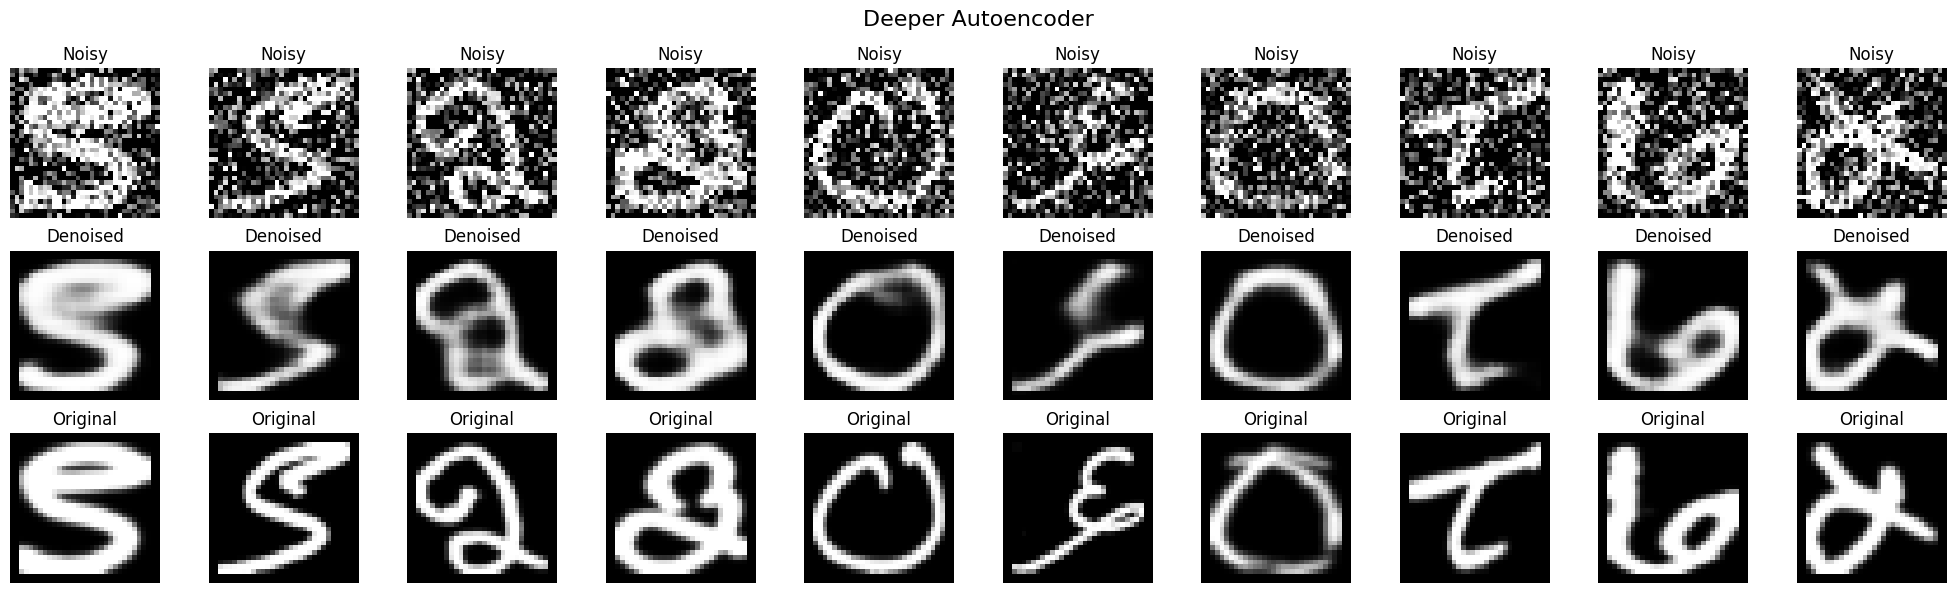

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


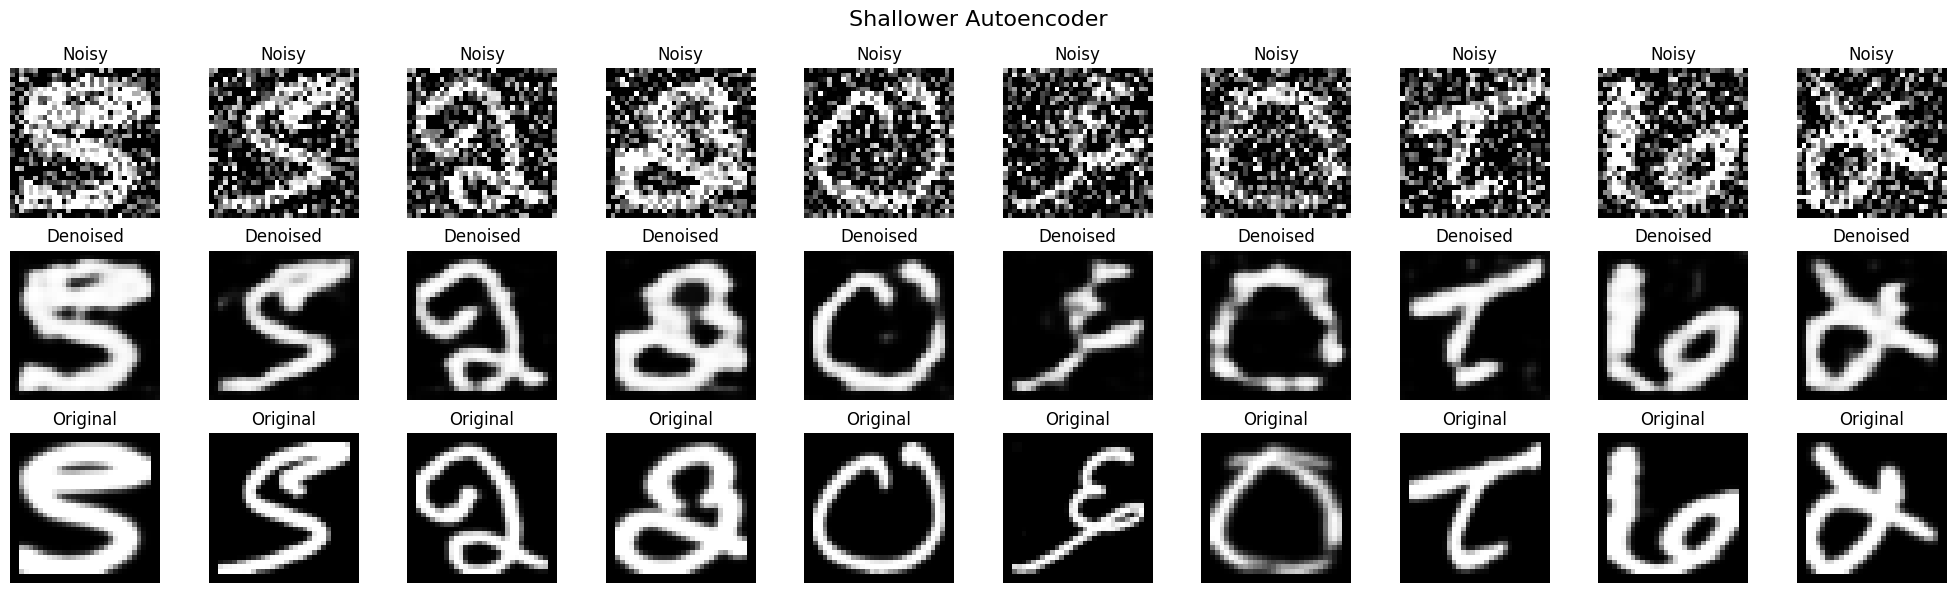

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


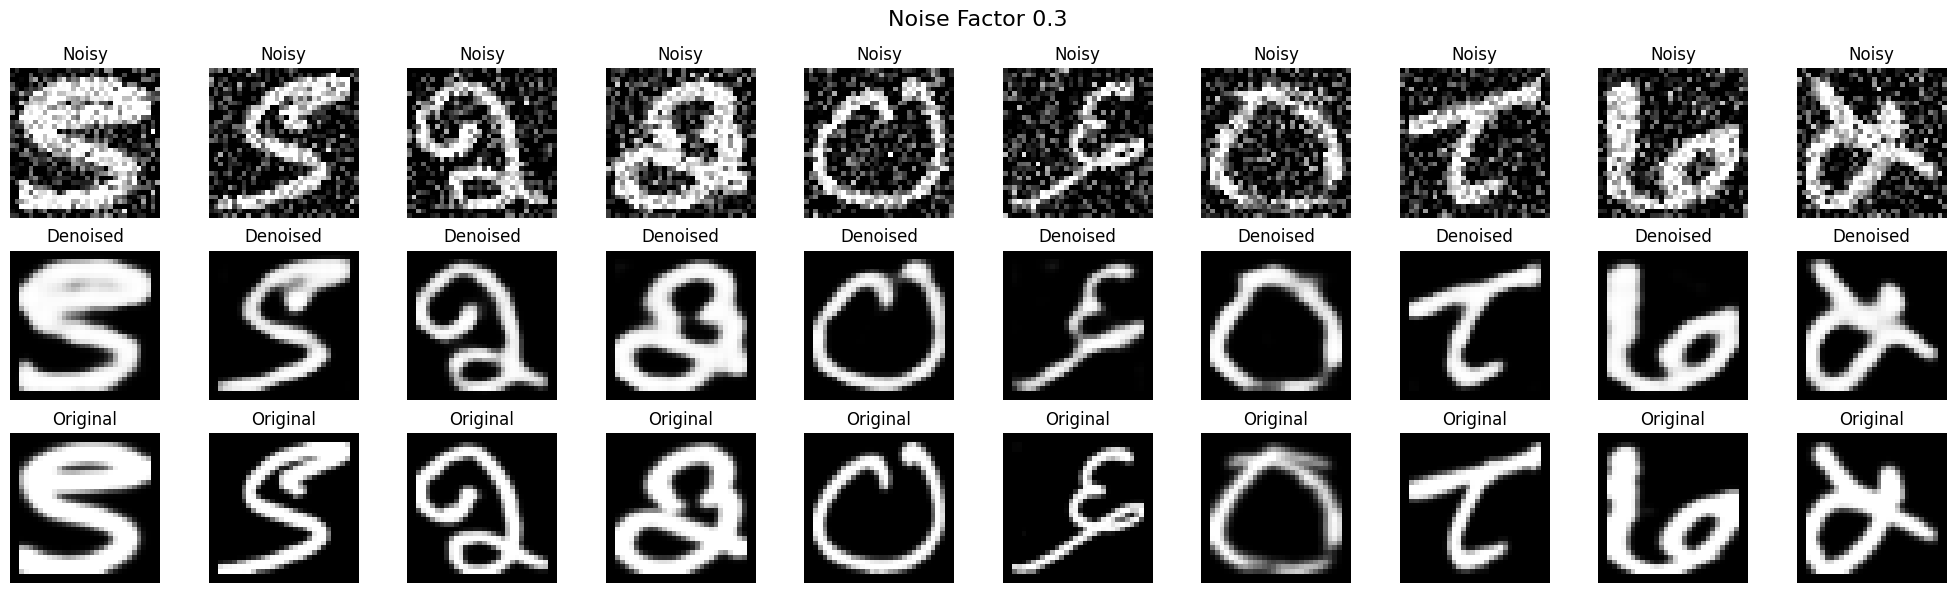

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


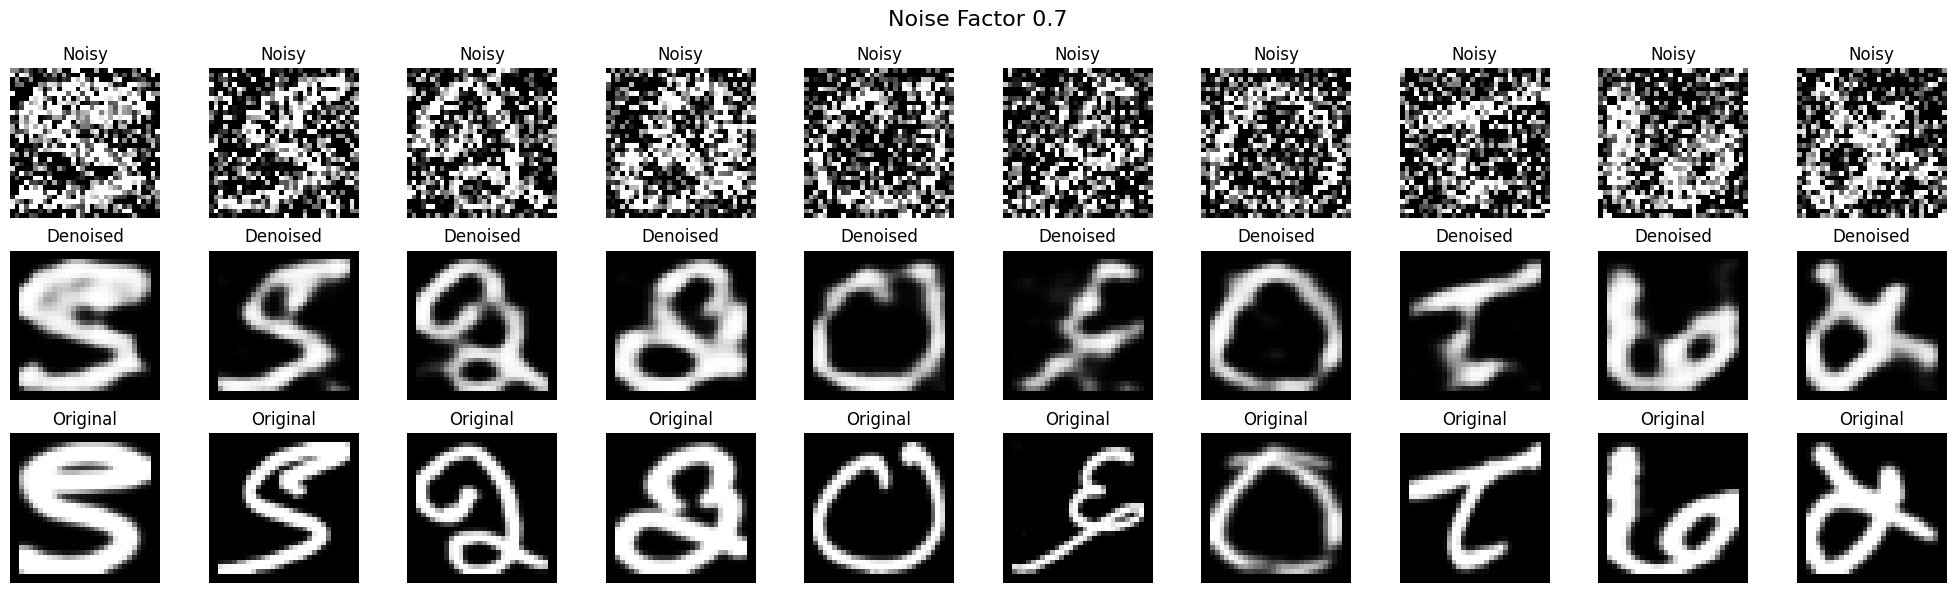

In [ ]:

import matplotlib.pyplot as plt

def visualize_results(model, x_test_noisy, x_test, title):
    decoded_imgs = model.predict(x_test_noisy[:10])
    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original + noise
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(32, 32), cmap="gray")
        plt.title("Noisy")
        plt.axis("off")

        # Display reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(32, 32), cmap="gray")
        plt.title("Denoised")
        plt.axis("off")

        # Display original
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(x_test[i].reshape(32, 32), cmap="gray")
        plt.title("Original")
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize deeper model
visualize_results(deeper_autoencoder, x_test_noisy, x_test, "Deeper Autoencoder")

# Visualize shallower model
visualize_results(shallower_autoencoder, x_test_noisy, x_test, "Shallower Autoencoder")

# Visualize low noise
visualize_results(model_low_noise, x_test_noisy_l, x_test_l, "Noise Factor 0.3")

# Visualize high noise
visualize_results(model_high_noise, x_test_noisy_h, x_test_h, "Noise Factor 0.7")


#Observations
Deeper Model: Cleaned the noisy images better and gave more accurate results, but it took longer to train.

Shallower Model: Trained quickly but didn’t clean the images as well.

Noise Factor (0.3): Images were easy to clean since they had very little noise.

Noise Factor (0.7): Too much noise made it hard for the model to recover the original image clearly.

Conclusion: Using more layers helps the model learn better, but it also needs more time. A medium noise level (around 0.5) gives the best balance between performance and difficulty.